# Applying Non-Unitary Operators

Apply the non-unitary matrix 
$$
\begin{bmatrix}
1 & 0 \\ 0 & 0
\end{bmatrix} = \frac1{2}\left( \hat{I} + \hat{Z}  \right) = |0\rangle\langle 0|$$
on the 1-qubit quantum state 
$$|x\rangle = \frac1{\sqrt{10}}\begin{bmatrix}\sqrt{3} \\ \sqrt{7}\end{bmatrix}$$

Solution: first we prepare state $|x\rangle$ using the `prepare_state` function. This is achieved by a rotation around the $y$-axis of $\theta = 2\arccos(\sqrt{0.3})\approx 1.982$ radians, as we are just encoding $x$ with real numbers. 

We then apply the linear combination of unitaries as found in the [Classiq Page](https://docs.classiq.io/latest/explore/tutorials/linear_combination_of_unitaries/linear_combination_of_unitaries/), where we use a controller to encode the coefficients $\alpha_i$ and apply each unitary one by one.

I encountered an issue when trying to make this linear combination of unitaries function generalizable. It seems that you cannot pass in a `list`, or `CArray` of `QArray` functions as an argument of a `qfunc`, which I was trying to do in `apply_lcu` below. 

In [40]:
from classiq import (
    qfunc, Output, QBit, QNum, QArray, QCallable, CArray, CReal,
    allocate, within_apply, control, 
    prepare_state, apply_to_all, inplace_prepare_state,
    set_constraints, Constraints, set_execution_preferences, QuantumProgram,
    create_model, synthesize, execute, write_qmod, show,
    qft, invert,
    IDENTITY, X, Y, Z, H, S, T,
)
from classiq.execution import ExecutionPreferences
import numpy as np
import matplotlib.pyplot as plt

def apply_lcu(controller: QNum, psi: QNum, unitaries: list[QCallable]) -> None:
    for i in range(len(unitaries)):
        control(controller == i, lambda: unitaries[i](psi))

@qfunc
def main(controller: Output[QNum], psi: Output[QNum]) -> None:
    error_bound = 0.01
    ctrl_probs = [0.5,0.5]
    unitaries = [IDENTITY, Z]
    # prepare psi
    prepare_state(probabilities=[0.3,0.7], bound=error_bound, out=psi)
    # Allocating the target and control qubits, respectively
    ncontrol = np.ceil(np.log2(len(ctrl_probs)))
    allocate(ncontrol, controller)
    # apply the linear combination
    within_apply(
        compute=lambda: inplace_prepare_state(
            probabilities=ctrl_probs, bound=error_bound, target=controller
        ),
        action=lambda: apply_lcu(controller, psi, unitaries),
    )

qmod = create_model(main)

Nevertheless, I still wanted to make this code somewhat general so that I could (maybe) make a robust non-unitary creation process, that solves general matrix sum decomposition problems and then applies it here.  

I worked around the problem above by using list comprehension instead, which can be compiled in `qmod`. The generated circuit is shown below:

`controller:`

`|0> –––––––——————— H ——— • ——— H ———— ( / ) = 0`

`target:⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀|⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀`

`|0> –– R_y(1.98) ——————— • ——————————————————— state has been unitary'd`


By taking the expectation of the final composite state, which includes both the target and the controller qubit(s), with the zero state of the controller, we achieve the desired linear combination of unitaries. This is shown below in the bar-plot, where we see only the states $|00\rangle$ and $|11\rangle$, but no mixed states, indicating that we have indeed projected our target state onto $|0\rangle$. We have equivalently entangled the measurements of the controller and the target states, which can be seen from the bar-plot nicely demonstrating the initial probability distribution of $\psi$. 

In [25]:
# workaround by using list comprehension
def combine_unitaries(psi_probs: list[float], ctrl_probs: list[float], 
                      unitaries: list[QCallable], error_bound = 0.01):
    assert len(ctrl_probs) == len(unitaries)
    assert sum(ctrl_probs) == 1
    assert sum(psi_probs) == 1
    ncontrol = np.ceil(np.log2(len(ctrl_probs)))
    
    def apply_lcu(controller: QNum, psi: QNum, unitaries: list[QCallable]) -> None:
        for i in range(len(unitaries)):
            control(controller == i, lambda: unitaries[i](psi))

    @qfunc
    def main(controller: Output[QNum], psi: Output[QNum]) -> None:
        prepare_state(probabilities=[0.3,0.7], bound=error_bound, out=psi)
        allocate(ncontrol, controller)
        within_apply(
            compute=lambda: inplace_prepare_state(
                probabilities=ctrl_probs, bound=error_bound, target=controller
            ),
            action=lambda: apply_lcu(controller, psi, unitaries),
        )
    
    qmod = create_model(main)
    write_qmod(qmod, 'lcu')
    """
    qfunc main(output controller: qnum, output psi: qnum) {
        prepare_state<[0.3, 0.7], 0.01>(psi);
        allocate<1.0>(controller);
        within {
            inplace_prepare_state<[0.5, 0.5], 0.01>(controller);
        } apply {
            control (controller == 0) {
            IDENTITY(psi);
            }
            control (controller == 1) {
            Z(psi);
            }
        }
    }
    """
    return qmod


psi_probs = [0.3,0.7]
ctrl_probs = [0.5,0.5]
unitaries = [IDENTITY, Z]

qmod = combine_unitaries(psi_probs, ctrl_probs, unitaries)
nshots = 10000
exmod = set_execution_preferences(
    qmod,
    ExecutionPreferences(num_shots=nshots, job_name=f"lcu_{nshots}", random_seed=767)
)
qprog = synthesize(exmod)

# open quantum program in IDE
show(qprog)

job = execute(qprog)
print(
    f"Job with {job.num_shots} shots is {job.status} on provider-backend={job.provider}-{job.backend_name} and can be accessed at {job.ide_url}"
)
# view job in IDE
job.open_in_ide()
results = job.result()[0].value
counts = results.counts
print(counts)

Opening: https://platform.classiq.io/circuit/09a50c51-9e86-43d8-a76f-1a622b296b8d?version=0.43.2
Job with 10000 shots is QUEUED on provider-backend=Classiq-simulator and can be accessed at https://platform.classiq.io/jobs/74bd5225-5a06-4bca-b916-da96bd3269ea
{'00': 2986, '11': 7014}


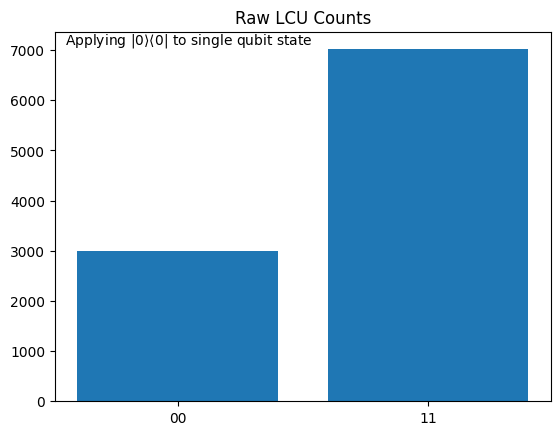

In [34]:
fig, ax = plt.subplots()
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()))
plt.title('Raw LCU Counts')
ax.text(0.02,1, r"Applying $|0\rangle\langle0|$ to single qubit state", 
    horizontalalignment='left',
    verticalalignment='top',
    transform = ax.transAxes)
plt.show()